<a href="https://colab.research.google.com/github/karenShaked/ML_Algo/blob/master/Task_1_karenFuchs_TalBamnolker_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 Data Gathering


In [ ]:
# Install the required packages
! pip install beautifulsoup4
! pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bs4 import BeautifulSoup as bs
import requests
import yfinance as yf
import pandas as pd
import numpy as np
import statistics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score


## Get Stocks daily OCHLV data

- S&P get list of stocks from wikipedia
- Download data from yfinance
  

In [ ]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [ ]:
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
all_stocks = [x.replace('\n','') for x in tickers] # remove the new line character

## Download data from yfinance

In [ ]:
all_df = pd.DataFrame()
start_date = '2018-07-01'
end_date = '2022-12-01'
fname_string = 'all_stocks_' + start_date + '_' + end_date + '.csv'


for tkr in all_stocks:
    single_stock_pd = yf.download(tickers=tkr, start=start_date, end=end_date, auto_adjust=True)
    single_stock_pd['stock'] = tkr
    single_stock_pd['sma_50'] = single_stock_pd['Close'].rolling(window=50).mean()  # Add new column for SMA
    all_df = all_df.append(single_stock_pd)

all_df.to_csv(fname_string)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## Read Locally and skip the download

In [ ]:
all_df = pd.read_csv(fname_string)
all_df

,Date,Open,High,Low,Close,Volume,stock,sma_50,Adj Close
0,2018-07-02,165.049191,165.412283,163.402573,165.099854,1815500.0,MMM,NaN,NaN
1,2018-07-03,165.918980,167.996232,165.083006,165.361664,1228900.0,MMM,NaN,NaN
2,2018-07-05,166.408660,166.754860,164.686048,166.636642,2019300.0,MMM,NaN,NaN
3,2018-07-06,166.425565,167.244647,165.834477,166.738007,1624500.0,MMM,NaN,NaN
4,2018-07-09,167.312204,169.592119,167.253101,169.330353,1967100.0,MMM,NaN,NaN
...,...,...,...,...,...,...,...,...,...
553156,2022-11-23,148.351409,150.845548,148.032167,150.117264,1445900.0,ZTS,147.678121,NaN
553157,2022-11-25,150.117266,150.496380,148.301525,149.748138,889500.0,ZTS,147.503681,NaN
553158,2022-11-28,149.109645,149.628415,147.473490,147.782761,1633300.0,ZTS,147.327366,NaN
553159,2022-11-29,147.224076,148.999902,146.086733,147.503418,1767100.0,ZTS,147.147654,NaN


In [ ]:
all_df['dt'] = pd.to_datetime(all_df['Date'])
all_df['t0'] = (all_df['dt'] - all_df['dt'].min()).dt.days.astype(float)


# Calculate Features & Target values for all stocks


In [ ]:
all_df['dt'] = pd.to_datetime(all_df['Date'])
all_df['t0'] = (all_df['dt'] - all_df['dt'].min()).dt.days.astype(float)

# Split the data to segments (6 months features, 3 months labelling)
FEATURES_SIZE = 180
LABELLING_SIZE = 90

start_train_features_day = 0
end_train_features_day = start_train_features_day + FEATURES_SIZE
start_train_labelling_day = end_train_features_day + 1
end_train_labelling_day = start_train_labelling_day + LABELLING_SIZE
all_features_train_df = all_df[(all_df['t0'] >= start_train_features_day)&(all_df['t0'] < end_train_features_day)]
all_labelling_train_df = all_df[(all_df['t0'] >= start_train_labelling_day)&(all_df['t0'] < end_train_labelling_day)]

In [ ]:
print(f'start_date:{start_train_features_day} , end_ft_day: {end_train_features_day}')

start_date:0 , end_ft_day: 180


In [ ]:
def calculate_returns(x):
  return 100*(x.iloc[-1]['Close'] - x.iloc[0]['Open'])/x.iloc[0]['Open']

<AxesSubplot:>

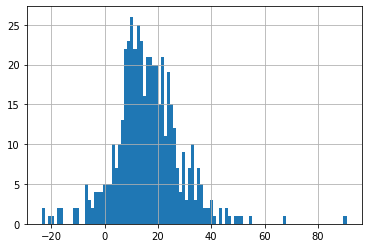

In [ ]:
# Calculating the train returns in the labelling 3 months
train_returns = all_labelling_train_df.groupby('stock').apply(lambda x: calculate_returns(x))
train_returns.hist(bins=100)

In [ ]:
# Make sure that the features are 6 months
print(all_features_train_df['t0'].max() - all_features_train_df['t0'].min())
# Make sure that the labelling is 90 days
print(all_labelling_train_df['t0'].max() - all_labelling_train_df['t0'].min())


179.0
88.0


In [ ]:
# Splitting the stocks to good and bad stocks based on greater or less then the median return
threshold = train_returns.median()
good = train_returns[train_returns>threshold].index
bad = train_returns[train_returns<threshold].index

### Calculating features for the train features months

In [ ]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = tables[0]
second_table = tables[1]
df_sector = first_table
df_sector

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [ ]:
def add_obv(df):
    copy = df.copy()
    copy["OBV"] = (np.sign(copy["Close"].diff()) * copy["Volume"]).fillna(0).cumsum()
    return copy

def max_volume(x):
  return x['Volume'].max()

def min_volume(x):
  return x['Volume'].min()

def avg(x):
  return (x['High']+x['Low'])/2

def calculate_OBV_diff(x):
  if(x.iloc[0]['OBV']==0):
    return 0
  return (x.iloc[-1]['OBV'] - x.iloc[0]['OBV'])/x.iloc[0]['OBV']

def median_avg(x):
  return statistics.median(x['avg'])

def return_sector(stock_name):
  return df_sector.loc[df_sector['Symbol']==stock_name]['GICS Sector']

def calculate_diff(x):
  return x['avg'].max()-x['avg'].min()

def extract_sma_50_and_stock(df):
    df = df[['sma_50', 'stock']].dropna()
    return df

def get_best_sma_df(df):
    # Group by stock and calculate mean SMA
    sma_means = df.groupby('stock')['sma_50'].mean()

    # Find the best SMA for each stock
    best_smas = {}
    for stock in sma_means.index:
        sma_values = df.loc[df['stock'] == stock, 'sma_50']
        best_sma = sma_values[sma_values >= sma_means[stock]].max()
        best_smas[stock] = best_sma

    # Create a new DataFrame with the best SMA for each stock
    best_sma_df = pd.DataFrame.from_dict(best_smas, orient='index', columns=['best_sma'])
    best_sma_df.index.name = 'stock'

    return best_sma_df

In [ ]:
# Creating a monthly df for calculations
features_df = all_features_train_df.copy()
features_df =add_obv(features_df)
print(features_df)
features_df['avg']=(features_df['High']+features_df['Low'])/2
features_df['dt'] = pd.to_datetime(features_df['Date'])
features_df['Quarter'] = features_df['dt'].dt.to_period('Q-MAR')
features_df['month_index'] = (features_df['t0'] / 30).astype(int)

sma_df = extract_sma_50_and_stock(all_df)
print(sma_df)
best_smas = get_best_sma_df(sma_df).reset_index()
print(best_smas)

df_returns=features_df.groupby(['stock']).apply(calculate_returns).reset_index()
df_returns.columns=['stock','returns']
print(df_returns)

monthly_features_df_returns = features_df.groupby(['stock','month_index']).apply(calculate_returns).reset_index()
print(monthly_features_df_returns)

sector_df=features_df.groupby(['stock']).apply(lambda x: return_sector(x.iloc[-1]['stock'])).reset_index()
print(sector_df)

sector_df['sector_index']=sector_df['stock']
sector_df = pd.get_dummies(sector_df['GICS Sector'])
print(sector_df)

last_quarter_df=features_df[features_df['Quarter']==features_df['Quarter'].max()]
median_last_quarter_df=last_quarter_df.groupby(['stock']).apply(median_avg).reset_index()
median_last_quarter_df.columns=['stock','median_price']
print(median_last_quarter_df)

last_quarter_diff_df=last_quarter_df.groupby(['stock']).apply(calculate_diff).reset_index()
last_quarter_diff_df.columns=['stock','diff']
#print(last_quarter_diff_df)

OBV_change_df=features_df.groupby(['stock']).apply(calculate_OBV_diff).reset_index()
OBV_change_df.columns=['stock','OBV_change']
print(OBV_change_df)

last_month_df=features_df[features_df['month_index']==features_df['month_index'].max()]
OBV_last_month_change_df=last_month_df.groupby(['stock']).apply(calculate_OBV_diff).reset_index()
OBV_last_month_change_df.columns=['stock','OBV_change_last_month']
print(OBV_last_month_change_df)

max_vol_df=last_month_df.groupby(['stock']).apply(max_volume).reset_index()
max_vol_df.columns=['stock','max_volume']
print(max_vol_df)

min_vol_df=last_month_df.groupby(['stock']).apply(min_volume).reset_index()
min_vol_df.columns=['stock','min_volume']
print(min_vol_df)


              Date        Open        High         Low       Close     Volume  \
0       2018-07-02  165.049191  165.412283  163.402573  165.099854  1815500.0   
1       2018-07-03  165.918980  167.996232  165.083006  165.361664  1228900.0   
2       2018-07-05  166.408660  166.754860  164.686048  166.636642  2019300.0   
3       2018-07-06  166.425565  167.244647  165.834477  166.738007  1624500.0   
4       2018-07-09  167.312204  169.592119  167.253101  169.330353  1967100.0   
...            ...         ...         ...         ...         ...        ...   
552168  2018-12-21   80.031839   81.559684   79.360371   79.486877  4091700.0   
552169  2018-12-24   78.737537   78.737537   76.781504   77.151299  1551400.0   
552170  2018-12-26   77.472457   80.713048   77.015076   80.693581  1869700.0   
552171  2018-12-27   79.632860   82.065735   79.000311   82.065735  2244700.0   
552172  2018-12-28   82.552303   83.291891   81.306672   82.221428  1797300.0   

       stock     sma_50  Ad

In [ ]:
# Calculating each stock best and worst monthly return to be used as our features
worst_monthly_return = monthly_features_df_returns.groupby('stock').min().reset_index()
best_monthly_return = monthly_features_df_returns.groupby('stock').max().reset_index()
train_df = best_monthly_return[['stock',0]]
train_df['worst'] = worst_monthly_return[0]
train_df['all_returns']=df_returns['returns']
train_df['best_sectors']=sector_df['Energy']+sector_df['Consumer Discretionary']+sector_df['Information Technology']+sector_df['Real Estate']+sector_df['Health Care']
train_df['median_last_quarter']=median_last_quarter_df['median_price']
train_df['OBV_change']=OBV_change_df['OBV_change']
train_df['last_month_obv_change']=OBV_last_month_change_df['OBV_change_last_month']
train_df['max_vol']=max_vol_df['max_volume']
train_df['min_vol']=min_vol_df['min_volume']
train_df['diff']=last_quarter_diff_df['diff']
train_df['sma_50']=best_smas.iloc[:,-1:]
print(train_df)

train_df.columns=['stock','best_month', 'worst_month','all_returns','best_sectors',
                 'median_last_quarter','OBV_change','last_month_obv_change','max_vol','min_vol','diff','sma_50']

    stock          0      worst  all_returns  best_sectors  \
0       A  14.643168 -12.167501     7.990687             1   
1     AAL  20.368288 -21.275065   -15.206289             0   
2     AAP  15.143778 -12.585180    15.240575             1   
3    AAPL  13.402918 -14.469516   -14.413607             1   
4    ABBV   8.556067 -13.204161     1.059428             1   
..    ...        ...        ...          ...           ...   
487   YUM   9.015810  -6.128498    19.176406             1   
488   ZBH  13.603040 -12.533185    -6.704403             1   
489  ZBRA  23.944695 -13.465381     9.923181             1   
490  ZION   2.964435 -15.559723   -21.979961             0   
491   ZTS   4.369539  -8.610065    -0.059275             1   

     median_last_quarter  OBV_change  last_month_obv_change      max_vol  \
0              64.792342    0.238558              -0.090024    4683100.0   
1              34.564930    0.019206               0.048976   14380100.0   
2             156.859295   

In [ ]:
# Adding a binary target column for our classification based on the labelling
train_df.loc[train_df['stock'].isin(good),'target'] = 1
train_df['target'].fillna(0,inplace=True)
train_df['target'].value_counts()
train_df

,stock,best_month,worst_month,all_returns,best_sectors,median_last_quarter,OBV_change,last_month_obv_change,max_vol,min_vol,diff,sma_50,target
0,A,14.643168,-12.167501,7.990687,1,64.792342,0.238558,-0.090024,4683100.0,1655000.0,11.643380,164.187100,1.0
1,AAL,20.368288,-21.275065,-15.206289,0,34.564930,0.019206,0.048976,14380100.0,5178100.0,10.104648,38.736011,0.0
2,AAP,15.143778,-12.585180,15.240575,1,156.859295,1.788431,-0.213847,1872900.0,649100.0,29.780770,225.624522,0.0
3,AAPL,13.402918,-14.469516,-14.413607,1,47.117313,0.743445,1.552825,382978400.0,127594400.0,19.695621,171.444983,1.0
4,ABBV,8.556067,-13.204161,1.059428,1,72.025075,0.416980,-0.151876,16044700.0,3838000.0,12.658136,152.622919,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,YUM,9.015810,-6.128498,19.176406,1,82.725611,-0.002745,-0.000372,5364600.0,1699500.0,6.336092,437.748918,0.0
488,ZBH,13.603040,-12.533185,-6.704403,1,108.367847,0.000880,0.000662,3159113.0,835330.0,31.106594,247.099532,1.0
489,ZBRA,23.944695,-13.465381,9.923181,1,167.454998,-0.000477,0.000071,939300.0,259700.0,36.905006,37.694637,1.0
490,ZION,2.964435,-15.559723,-21.979961,0,42.125751,0.003725,0.002807,4743300.0,1177100.0,11.228752,144.738810,0.0


# Training the model

In [ ]:
# Training a Random Forest ML model to predict if the stock return will be above the median return in the labelling period
# based on best and worst month in the feature period
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(train_df[['best_month','worst_month',
                  'all_returns',
                  'best_sectors',
                  'median_last_quarter',
                  'OBV_change',
                  'last_month_obv_change',
                  'max_vol',
                  'min_vol',
                  'diff',
                  'sma_50'
                  ]], train_df['target'])

RandomForestClassifier(max_depth=3, random_state=0)

# Testing the model
- From the last day of the label dataset ( 180+90+ start day)
- Start day: 270
- Features: from 270  to 450 ( 180 + 270 )
- Prediction: 540 (450 - 90)


In [ ]:
def test_the_model(start_test_features_day):
  end_test_features_day = start_test_features_day + FEATURES_SIZE
  start_test_labelling_day = end_test_features_day + 1
  end_test_labelling_day = start_test_labelling_day + LABELLING_SIZE
  print(f'start_test_feature_day: {start_test_features_day} \
        end_test_features_day:{end_test_features_day}\
        start_test_labelling_day:{start_test_labelling_day} \
        end_test_labelling_day:{end_test_labelling_day}')


  all_features_test_df = all_df[(all_df['t0'] >= start_test_features_day)&(all_df['t0'] < end_test_features_day)]

  all_labelling_test_df = all_df[(all_df['t0'] >= start_test_labelling_day) & (all_df['t0'] < end_test_labelling_day)]


  #print(all_features_test_df['t0'].min())
  #print(all_features_test_df['t0'].max())
  #print(all_labelling_test_df['t0'].min())
  #print(all_labelling_test_df['t0'].max())
  features_df = all_features_test_df.copy()
  #print(features_df)
  features_df =add_obv(features_df)
  features_df['avg']=(features_df['High']+features_df['Low'])/2
  features_df['dt'] = pd.to_datetime(features_df['Date'])
  features_df['Quarter'] = features_df['dt'].dt.to_period('Q-MAR')
  features_df['month_index'] = (features_df['t0'] / 30).astype(int)

  sma_df = extract_sma_50_and_stock(features_df)
  #print(sma_df)
  best_smas = get_best_sma_df(features_df).reset_index()
  #print(best_smas)

  df_returns=features_df.groupby(['stock']).apply(calculate_returns).reset_index()
  df_returns.columns=['stock','returns']
  #print(df_returns)

  monthly_features_df_returns = features_df.groupby(['stock','month_index']).apply(calculate_returns).reset_index()
  #print(monthly_features_df_returns)

  sector_df=features_df.groupby(['stock']).apply(lambda x: return_sector(x.iloc[-1]['stock'])).reset_index()
  #print(sector_df)

  sector_df['sector_index']=sector_df['stock']
  sector_df = pd.get_dummies(sector_df['GICS Sector'])
  #print(sector_df)

  last_quarter_df=features_df[features_df['Quarter']==features_df['Quarter'].max()]
  median_last_quarter_df=last_quarter_df.groupby(['stock']).apply(median_avg).reset_index()
  median_last_quarter_df.columns=['stock','median_price']
  #print(median_last_quarter_df)

  last_quarter_diff_df=last_quarter_df.groupby(['stock']).apply(calculate_diff).reset_index()
  last_quarter_diff_df.columns=['stock','diff']
  #print(last_quarter_diff_df)

  OBV_change_df=features_df.groupby(['stock']).apply(calculate_OBV_diff).reset_index()
  OBV_change_df.columns=['stock','OBV_change']
  #print(OBV_change_df)

  last_month_df=features_df[features_df['month_index']==features_df['month_index'].max()]
  #print(last_month_df)
  OBV_last_month_change_df=last_month_df.groupby(['stock']).apply(calculate_OBV_diff).reset_index()
  OBV_last_month_change_df.columns=['stock','OBV_change_last_month']
  #print(OBV_last_month_change_df)

  max_vol_df=last_month_df.groupby(['stock']).apply(max_volume).reset_index()
  max_vol_df.columns=['stock','max_volume']
  #print(max_vol_df)

  min_vol_df=last_month_df.groupby(['stock']).apply(min_volume).reset_index()
  min_vol_df.columns=['stock','min_volume']
  #print(min_vol_df)

  worst_monthly_return = monthly_features_df_returns.groupby('stock').min().reset_index()
  best_monthly_return = monthly_features_df_returns.groupby('stock').max().reset_index()

  test_df = best_monthly_return[['stock',0]]
  test_df['worst'] = worst_monthly_return[0]
  test_df['all_returns']=df_returns['returns']
  test_df['best_sectors']=sector_df['Energy']+sector_df['Consumer Discretionary']+sector_df['Information Technology']+sector_df['Real Estate']+sector_df['Health Care']
  test_df['median_last_quarter']=median_last_quarter_df['median_price']
  test_df['OBV_change']=OBV_change_df['OBV_change']
  test_df['last_month_obv_change']=OBV_last_month_change_df['OBV_change_last_month']
  test_df['max_vol']=max_vol_df['max_volume']
  test_df['min_vol']=min_vol_df['min_volume']
  test_df['diff']=last_quarter_diff_df['diff']
  test_df['sma_50']=best_smas.iloc[:,-1:]

  test_df.columns=['stock','best_month', 'worst_month','all_returns','best_sectors',
                    'median_last_quarter','OBV_change','last_month_obv_change','max_vol','min_vol','diff','sma_50']

  test_df = test_df.dropna()
  test_df['predicted_y'] = clf.predict(test_df[[
                    'best_month', 'worst_month',
                    'all_returns',
                    'best_sectors',
                    'median_last_quarter',
                    'OBV_change',
                    'last_month_obv_change',
                    'max_vol',
                    'min_vol',
                    'diff',
                    'sma_50'
                    ]])

  test_df['predicted_y'].value_counts()
  test_returns = all_labelling_test_df.groupby('stock').apply(lambda x:calculate_returns(x))
  label_threshold = test_returns.median()
  good_test = test_returns[test_returns > label_threshold].index
  test_df.loc[test_df['stock'].isin(good_test),'actual_y'] = 1
  test_df['actual_y'].fillna(0,inplace=True)
  test_df['actual_y'].value_counts()
  true_positive = len(test_df[(test_df['predicted_y'] == test_df['actual_y'])&(test_df['predicted_y']==True)])
  true_negative = len(test_df[(test_df['predicted_y'] == test_df['actual_y'])&(test_df['predicted_y']==False)])
  false_positive = len(test_df[(test_df['predicted_y'] != test_df['actual_y'])&(test_df['predicted_y']==True)])
  false_negative = len(test_df[(test_df['predicted_y'] != test_df['actual_y'])&(test_df['predicted_y']==False)])
  print(
  f'''
  Train results:
    True positive: {true_positive},
    True negative: {true_negative},
    False positive: {false_positive},
    False negative: {false_negative}
  ''')
  matrix = confusion_matrix(test_df['actual_y'], test_df['predicted_y'])
  disp = ConfusionMatrixDisplay(matrix, display_labels=[0,1])
  disp.plot()
  precision = precision_score(test_df['actual_y'], test_df['predicted_y'])
  recall = recall_score(test_df['actual_y'], test_df['predicted_y'])
  results = []
  results.append({'precision': precision, 'recall': recall})
  print(results)



start_test_feature_day: 0         end_test_features_day:180        start_test_labelling_day:181         end_test_labelling_day:271

  Train results:
    True positive: 187,
    True negative: 168,
    False positive: 77,
    False negative: 59
  
[{'precision': 0.7083333333333334, 'recall': 0.7601626016260162}]


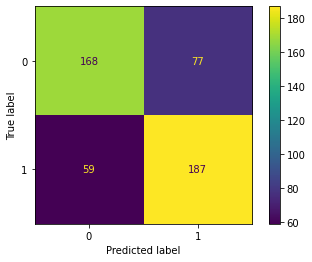

In [ ]:
test_the_model(0)

start_test_feature_day: 30         end_test_features_day:210        start_test_labelling_day:211         end_test_labelling_day:301

  Train results:
    True positive: 93,
    True negative: 186,
    False positive: 59,
    False negative: 153
  
[{'precision': 0.6118421052631579, 'recall': 0.3780487804878049}]


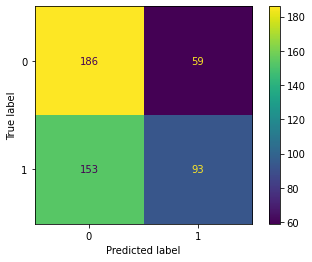

In [ ]:
test_the_model(30)

start_test_feature_day: 60         end_test_features_day:240        start_test_labelling_day:241         end_test_labelling_day:331

  Train results:
    True positive: 89,
    True negative: 151,
    False positive: 93,
    False negative: 159
  
[{'precision': 0.489010989010989, 'recall': 0.3588709677419355}]


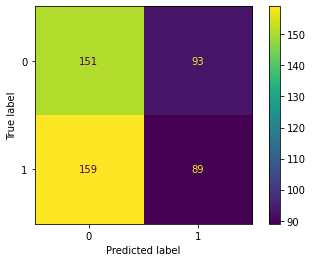

In [ ]:
test_the_model(60)

start_test_feature_day: 90         end_test_features_day:270        start_test_labelling_day:271         end_test_labelling_day:361

  Train results:
    True positive: 97,
    True negative: 143,
    False positive: 101,
    False negative: 151
  
[{'precision': 0.4898989898989899, 'recall': 0.3911290322580645}]


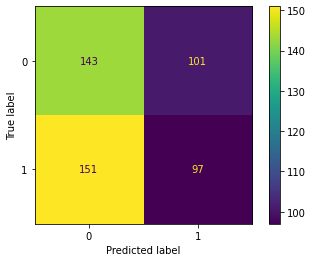

In [ ]:
test_the_model(90)

start_test_feature_day: 120         end_test_features_day:300        start_test_labelling_day:301         end_test_labelling_day:391

  Train results:
    True positive: 92,
    True negative: 150,
    False positive: 94,
    False negative: 156
  
[{'precision': 0.4946236559139785, 'recall': 0.3709677419354839}]


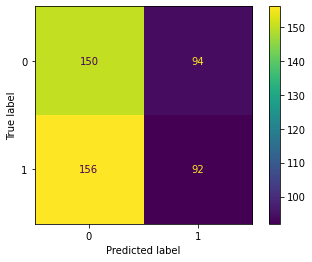

In [ ]:
test_the_model(120)

start_test_feature_day: 150         end_test_features_day:330        start_test_labelling_day:331         end_test_labelling_day:421

  Train results:
    True positive: 101,
    True negative: 169,
    False positive: 77,
    False negative: 147
  
[{'precision': 0.5674157303370787, 'recall': 0.40725806451612906}]


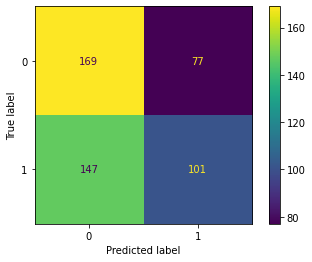

In [ ]:
test_the_model(150)

start_test_feature_day: 180         end_test_features_day:360        start_test_labelling_day:361         end_test_labelling_day:451

  Train results:
    True positive: 64,
    True negative: 165,
    False positive: 82,
    False negative: 184
  
[{'precision': 0.4383561643835616, 'recall': 0.25806451612903225}]


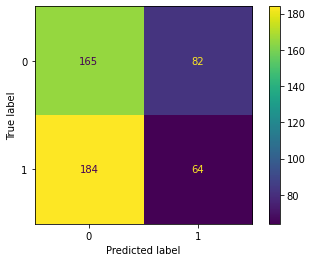

In [ ]:
test_the_model(180)

start_test_feature_day: 210         end_test_features_day:390        start_test_labelling_day:391         end_test_labelling_day:481

  Train results:
    True positive: 62,
    True negative: 176,
    False positive: 71,
    False negative: 186
  
[{'precision': 0.46616541353383456, 'recall': 0.25}]


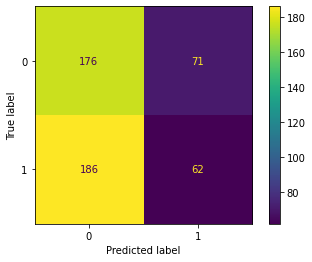

In [ ]:
test_the_model(210)

start_test_feature_day: 240         end_test_features_day:420        start_test_labelling_day:421         end_test_labelling_day:511

  Train results:
    True positive: 79,
    True negative: 199,
    False positive: 49,
    False negative: 169
  
[{'precision': 0.6171875, 'recall': 0.3185483870967742}]


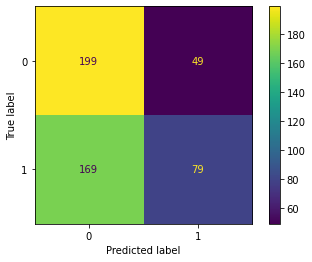

In [ ]:
test_the_model(240)

start_test_feature_day: 270         end_test_features_day:450        start_test_labelling_day:451         end_test_labelling_day:541

  Train results:
    True positive: 109,
    True negative: 189,
    False positive: 59,
    False negative: 139
  
[{'precision': 0.6488095238095238, 'recall': 0.43951612903225806}]


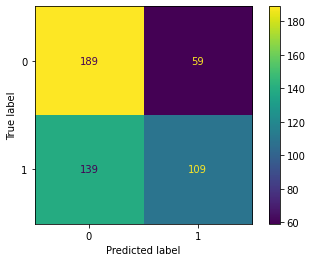

In [ ]:
test_the_model(270)

start_test_feature_day: 300         end_test_features_day:480        start_test_labelling_day:481         end_test_labelling_day:571

  Train results:
    True positive: 84,
    True negative: 194,
    False positive: 54,
    False negative: 164
  
[{'precision': 0.6086956521739131, 'recall': 0.3387096774193548}]


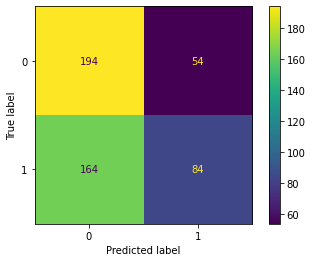

In [ ]:
test_the_model(300)

start_test_feature_day: 330         end_test_features_day:510        start_test_labelling_day:511         end_test_labelling_day:601

  Train results:
    True positive: 80,
    True negative: 176,
    False positive: 72,
    False negative: 168
  
[{'precision': 0.5263157894736842, 'recall': 0.3225806451612903}]


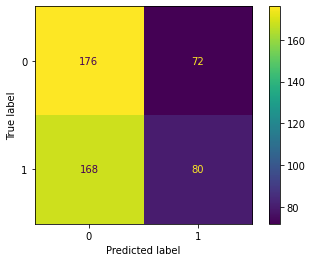

In [ ]:
test_the_model(330)

start_test_feature_day: 360         end_test_features_day:540        start_test_labelling_day:541         end_test_labelling_day:631

  Train results:
    True positive: 80,
    True negative: 152,
    False positive: 97,
    False negative: 167
  
[{'precision': 0.4519774011299435, 'recall': 0.32388663967611336}]


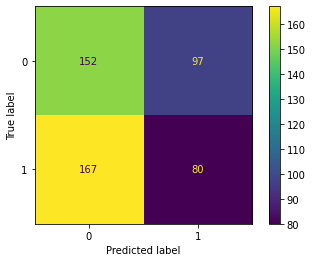

In [ ]:
test_the_model(360)

start_test_feature_day: 390         end_test_features_day:570        start_test_labelling_day:571         end_test_labelling_day:661

  Train results:
    True positive: 84,
    True negative: 163,
    False positive: 86,
    False negative: 163
  
[{'precision': 0.49411764705882355, 'recall': 0.340080971659919}]


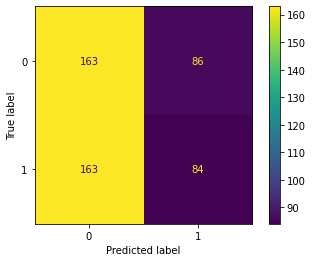

In [ ]:
test_the_model(390)

# portfolio choosing

In [ ]:
portfolio_df = pd.DataFrame()
start_date = '2021-06-01'
end_date = '2022-12-01'
fname_string = 'all_stocks_' + start_date + '_' + end_date + '.csv'

for tkr in all_stocks:
    single_stock_pd = yf.download(tickers=tkr, start=start_date, end=end_date, auto_adjust=True)
    single_stock_pd['stock'] = tkr
    single_stock_pd['sma_50'] = single_stock_pd['Close'].rolling(window=50).mean()  # Add new column for SMA
    portfolio_df = portfolio_df.append(single_stock_pd)
portfolio_df.to_csv(fname_string)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
portfolio_df = pd.read_csv(fname_string)
portfolio_df = portfolio_df.reset_index()
portfolio_df['dt'] = pd.to_datetime(portfolio_df['Date'])
portfolio_df['t0'] = (portfolio_df['dt'] - portfolio_df['dt'].min()).dt.days.astype(float)

# Split the data to segments (6 months features, 3 months labelling)
FEATURES_SIZE = 180
LABELLING_SIZE = 90

start_train_features_day = 0
end_train_features_day = start_train_features_day + FEATURES_SIZE
start_train_labelling_day = end_train_features_day + 1
end_train_labelling_day = start_train_labelling_day + LABELLING_SIZE

all_features_port = portfolio_df[(portfolio_df['t0'] >= start_train_features_day)&(portfolio_df['t0'] < end_train_features_day)]
all_labelling_port = portfolio_df[(portfolio_df['t0'] >= start_train_labelling_day)&(portfolio_df['t0'] < end_train_labelling_day)]

train_returns = all_labelling_port.groupby('stock').apply(lambda x: calculate_returns(x))

features_df = all_features_port.copy()
features_df =add_obv(features_df)
features_df['avg']=(features_df['High']+features_df['Low'])/2
features_df['dt'] = pd.to_datetime(features_df['Date'])
features_df['Quarter'] = features_df['dt'].dt.to_period('Q-MAR')
features_df['month_index'] = (features_df['t0'] / 30).astype(int)

sma_df = extract_sma_50_and_stock(all_df)
best_smas = get_best_sma_df(sma_df).reset_index()
df_returns=features_df.groupby(['stock']).apply(calculate_returns).reset_index()
df_returns.columns=['stock','returns']
monthly_features_df_returns = features_df.groupby(['stock','month_index']).apply(calculate_returns).reset_index()
sector_df=features_df.groupby(['stock']).apply(lambda x: return_sector(x.iloc[-1]['stock'])).reset_index()
print(sector_df)

sector_df['sector_index']=sector_df['stock']
sector_df = pd.get_dummies(sector_df['GICS Sector'])
print(sector_df)

last_quarter_df=features_df[features_df['Quarter']==features_df['Quarter'].max()]
median_last_quarter_df=last_quarter_df.groupby(['stock']).apply(median_avg).reset_index()
median_last_quarter_df.columns=['stock','median_price']

last_quarter_diff_df=last_quarter_df.groupby(['stock']).apply(calculate_diff).reset_index()
last_quarter_diff_df.columns=['stock','diff']

OBV_change_df=features_df.groupby(['stock']).apply(calculate_OBV_diff).reset_index()
OBV_change_df.columns=['stock','OBV_change']

last_month_df=features_df[features_df['month_index']==features_df['month_index'].max()]
OBV_last_month_change_df=last_month_df.groupby(['stock']).apply(calculate_OBV_diff).reset_index()
OBV_last_month_change_df.columns=['stock','OBV_change_last_month']

max_vol_df=last_month_df.groupby(['stock']).apply(max_volume).reset_index()
max_vol_df.columns=['stock','max_volume']

min_vol_df=last_month_df.groupby(['stock']).apply(min_volume).reset_index()
min_vol_df.columns=['stock','min_volume']


    stock  level_1             GICS Sector
0       A       12             Health Care
1     AAL       29             Industrials
2     AAP        9  Consumer Discretionary
3    AAPL       44  Information Technology
4    ABBV        3             Health Care
..    ...      ...                     ...
494   YUM      498  Consumer Discretionary
495   ZBH      500             Health Care
496  ZBRA      499  Information Technology
497  ZION      501              Financials
498   ZTS      502             Health Care

[499 rows x 3 columns]
     Communication Services  Consumer Discretionary  Consumer Staples  Energy  \
0                         0                       0                 0       0   
1                         0                       0                 0       0   
2                         0                       1                 0       0   
3                         0                       0                 0       0   
4                         0                       0    

In [ ]:
# Splitting the stocks to good and bad stocks based on greater or less then the median return
threshold = train_returns.median()
good = train_returns[train_returns>threshold].index
bad = train_returns[train_returns<threshold].index


In [ ]:
worst_monthly_return = monthly_features_df_returns.groupby('stock').min().reset_index()
best_monthly_return = monthly_features_df_returns.groupby('stock').max().reset_index()
train_df = best_monthly_return[['stock',0]]
train_df['worst'] = worst_monthly_return[0]
train_df['all_returns']=df_returns['returns']
train_df['best_sectors']=sector_df['Energy']+sector_df['Consumer Discretionary']+sector_df['Information Technology']+sector_df['Real Estate']+sector_df['Health Care']
train_df['median_last_quarter']=median_last_quarter_df['median_price']
train_df['OBV_change']=OBV_change_df['OBV_change']
train_df['last_month_obv_change']=OBV_last_month_change_df['OBV_change_last_month']
train_df['max_vol']=max_vol_df['max_volume']
train_df['min_vol']=min_vol_df['min_volume']
train_df['diff']=last_quarter_diff_df['diff']
train_df['sma_50']=best_smas.iloc[:,-1:]
print(train_df)

train_df.columns=['stock','best_month', 'worst_month','all_returns','best_sectors',
                 'median_last_quarter','OBV_change','last_month_obv_change','max_vol','min_vol','diff','sma_50']

    stock          0      worst  all_returns  best_sectors  \
0       A  12.826998  -8.029460     9.549121             1   
1     AAL   5.618528 -14.059972   -28.079417             0   
2     AAP   7.669480  -4.395134    19.581076             1   
3    AAPL   9.497915  -4.758382    25.738842             1   
4    ABBV   4.113807 -10.430583     4.869953             1   
..    ...        ...        ...          ...           ...   
494   YUM  13.767424  -6.969333     3.436356             1   
495   ZBH   1.188870 -12.160005   -25.648119             1   
496  ZBRA  11.821597 -10.258495    17.656893             1   
497  ZION  12.616939  -9.315490    11.497163             0   
498   ZTS   9.354419  -5.421454    23.962440             1   

     median_last_quarter  OBV_change  last_month_obv_change      max_vol  \
0             155.240291   -0.421203               0.141383    3140600.0   
1              19.892500   -0.149340              -0.035012   84177500.0   
2             219.535919   

In [ ]:

train_df.loc[train_df['stock'].isin(good),'target'] = 1
train_df['target'].fillna(0,inplace=True)
train_df['target'].value_counts()


0.0    250
1.0    249
Name: target, dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(train_df[['best_month','worst_month',
                  'all_returns',
                  'best_sectors',
                  'median_last_quarter',
                  'OBV_change',
                  'last_month_obv_change',
                  'max_vol',
                  'min_vol',
                  'diff',
                  'sma_50'
                  ]], train_df['target'])

RandomForestClassifier(max_depth=3, random_state=0)

start_test_feature_day: 0       end_test_features_day:180      start_test_labelling_day:181       end_test_labelling_day:271

Train results:
  True positive: 199,
  True negative: 184,
  False positive: 66,
  False negative: 50

[{'precision': 0.7509433962264151, 'recall': 0.7991967871485943}]


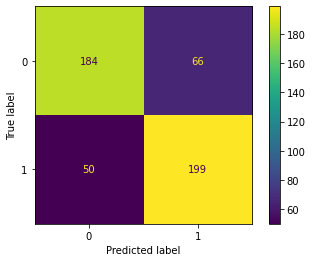

In [ ]:
start_test_features_day=0

end_test_features_day = start_test_features_day + FEATURES_SIZE
start_test_labelling_day = end_test_features_day + 1
end_test_labelling_day = start_test_labelling_day + LABELLING_SIZE
print(f'start_test_feature_day: {start_test_features_day} \
      end_test_features_day:{end_test_features_day}\
      start_test_labelling_day:{start_test_labelling_day} \
      end_test_labelling_day:{end_test_labelling_day}')


all_features_test_df = portfolio_df[(portfolio_df['t0'] >= start_test_features_day)&(portfolio_df['t0'] < end_test_features_day)]

all_labelling_test_df = portfolio_df[(portfolio_df['t0'] >= start_test_labelling_day) & (portfolio_df['t0'] < end_test_labelling_day)]


 # print(all_features_test_df['t0'].min())
 # print(all_features_test_df['t0'].max())
 # print(all_labelling_test_df['t0'].min())
 # print(all_labelling_test_df['t0'].max())
features_df = all_features_test_df.copy()
  #print(features_df)
features_df =add_obv(features_df)
features_df['avg']=(features_df['High']+features_df['Low'])/2
features_df['dt'] = pd.to_datetime(features_df['Date'])
features_df['Quarter'] = features_df['dt'].dt.to_period('Q-MAR')
features_df['month_index'] = (features_df['t0'] / 30).astype(int)

sma_df = extract_sma_50_and_stock(features_df)
 # print(sma_df)
best_smas = get_best_sma_df(features_df).reset_index()
#  print(best_smas)

df_returns=features_df.groupby(['stock']).apply(calculate_returns).reset_index()
df_returns.columns=['stock','returns']
 # print(df_returns)

monthly_features_df_returns = features_df.groupby(['stock','month_index']).apply(calculate_returns).reset_index()
 # print(monthly_features_df_returns)

sector_df=features_df.groupby(['stock']).apply(lambda x: return_sector(x.iloc[-1]['stock'])).reset_index()
 # print(sector_df)

sector_df['sector_index']=sector_df['stock']
sector_df = pd.get_dummies(sector_df['GICS Sector'])
 # print(sector_df)

last_quarter_df=features_df[features_df['Quarter']==features_df['Quarter'].max()]
median_last_quarter_df=last_quarter_df.groupby(['stock']).apply(median_avg).reset_index()
median_last_quarter_df.columns=['stock','median_price']
 # print(median_last_quarter_df)

last_quarter_diff_df=last_quarter_df.groupby(['stock']).apply(calculate_diff).reset_index()
last_quarter_diff_df.columns=['stock','diff']
 # print(last_quarter_diff_df)

OBV_change_df=features_df.groupby(['stock']).apply(calculate_OBV_diff).reset_index()
OBV_change_df.columns=['stock','OBV_change']
  #print(OBV_change_df)

last_month_df=features_df[features_df['month_index']==features_df['month_index'].max()]
 # print(last_month_df)
OBV_last_month_change_df=last_month_df.groupby(['stock']).apply(calculate_OBV_diff).reset_index()
OBV_last_month_change_df.columns=['stock','OBV_change_last_month']
 # print(OBV_last_month_change_df)

max_vol_df=last_month_df.groupby(['stock']).apply(max_volume).reset_index()
max_vol_df.columns=['stock','max_volume']
  #print(max_vol_df)

min_vol_df=last_month_df.groupby(['stock']).apply(min_volume).reset_index()
min_vol_df.columns=['stock','min_volume']
  #print(min_vol_df)

worst_monthly_return = monthly_features_df_returns.groupby('stock').min().reset_index()
best_monthly_return = monthly_features_df_returns.groupby('stock').max().reset_index()

test_df = best_monthly_return[['stock',0]]
test_df['worst'] = worst_monthly_return[0]
test_df['all_returns']=df_returns['returns']
test_df['best_sectors']=sector_df['Energy']+sector_df['Consumer Discretionary']+sector_df['Information Technology']+sector_df['Real Estate']+sector_df['Health Care']
test_df['median_last_quarter']=median_last_quarter_df['median_price']
test_df['OBV_change']=OBV_change_df['OBV_change']
test_df['last_month_obv_change']=OBV_last_month_change_df['OBV_change_last_month']
test_df['max_vol']=max_vol_df['max_volume']
test_df['min_vol']=min_vol_df['min_volume']
test_df['diff']=last_quarter_diff_df['diff']
test_df['sma_50']=best_smas.iloc[:,-1:]

test_df.columns=['stock','best_month', 'worst_month','all_returns','best_sectors',
                    'median_last_quarter','OBV_change','last_month_obv_change','max_vol','min_vol','diff','sma_50']

test_df = test_df.dropna()
test_df['predicted_y'] = clf.predict(test_df[[
                    'best_month', 'worst_month',
                    'all_returns',
                    'best_sectors',
                    'median_last_quarter',
                    'OBV_change',
                    'last_month_obv_change',
                    'max_vol',
                    'min_vol',
                    'diff',
                    'sma_50'
                    ]])

test_df['predicted_y'].value_counts()
test_returns = all_labelling_test_df.groupby('stock').apply(lambda x:calculate_returns(x))
label_threshold = test_returns.median()
good_test = test_returns[test_returns > label_threshold].index
test_df.loc[test_df['stock'].isin(good_test),'actual_y'] = 1
test_df['actual_y'].fillna(0,inplace=True)
test_df['actual_y'].value_counts()
true_positive = len(test_df[(test_df['predicted_y'] == test_df['actual_y'])&(test_df['predicted_y']==True)])
true_negative = len(test_df[(test_df['predicted_y'] == test_df['actual_y'])&(test_df['predicted_y']==False)])
false_positive = len(test_df[(test_df['predicted_y'] != test_df['actual_y'])&(test_df['predicted_y']==True)])
false_negative = len(test_df[(test_df['predicted_y'] != test_df['actual_y'])&(test_df['predicted_y']==False)])
print(
f'''
Train results:
  True positive: {true_positive},
  True negative: {true_negative},
  False positive: {false_positive},
  False negative: {false_negative}
''')
matrix = confusion_matrix(test_df['actual_y'], test_df['predicted_y'])
disp = ConfusionMatrixDisplay(matrix, display_labels=[0,1])
disp.plot()
precision = precision_score(test_df['actual_y'], test_df['predicted_y'])
recall = recall_score(test_df['actual_y'], test_df['predicted_y'])
results = []
results.append({'precision': precision, 'recall': recall})
print(results)



In [ ]:
port_stock = test_df[(test_df['best_sectors']==1) & (test_df['predicted_y']==1.0)]
stock_names = port_stock['stock']
port_list = stock_names.values.tolist()
print(len(port_list))
mean = port_stock['all_returns'].mean()
print('the return of the portfolio is')
print(mean)
mean_sp = test_df['all_returns'].mean()
print('the return of the s&p is')
print(mean_sp)

port_std = np.std(port_stock['all_returns'])
print('the std of the portfolio is')
print(port_std)
sp_std = np.std(test_df['all_returns'])
print('the std of the s&p is')
print(sp_std)

sharpe_ratio_port = mean / port_std
print('the sharpe ratio of the portfolio is')
print(sharpe_ratio_port)
sharpe_ratio_sp = mean_sp / sp_std
print('the sharpe ratio_sp of the s&p is')
print(sharpe_ratio_sp)


106
the return of the portfolio is
-4.149556777506373
the return of the s&p is
5.004407022913552
the std of the portfolio is
16.150163239815814
the std of the s&p is
18.938578825592575
the sharpe ratio of the portfolio is
-0.2569359031168342
the sharpe ratio_sp of the s&p is
0.26424406334813605
